In [1]:
import argparse
import logging
import IPython
import numpy as np
import os
import sys
import time
import matplotlib.pyplot as plt
from math import sqrt, atan2, ceil

from autolab_core import RigidTransform, YamlConfig, Point

from gqcnn import RgbdImageState, ParallelJawGrasp
from gqcnn import Grasp2D
from gqcnn import CrossEntropyAntipodalGraspingPolicy, AntipodalDepthImageGraspSampler
from gqcnn import Visualizer as vis
from gqcnn import ImageMode, TrainingMode, PreprocMode, InputDataMode, GeneralConstants, ImageFileTemplates

from perception import ColorImage, CameraIntrinsics

In [2]:
cfg = YamlConfig('/Users/stephenhansen/Code/gqcnn/cfg/tools/color_training.yaml')

In [3]:
def view_cornell_grasp(cfg, idx, is_positive_example=True):
    directory = cfg['raw_data_dir']
    if idx<10:
        file_name= "pcd000{}r".format(idx)
    elif idx<100:
        file_name= "pcd00{}r".format(idx)
    else:
        file_name= "pcd0{}r".format(idx)

    if is_positive_example:
        last= 'cpos.txt'
    else: 
        last= 'cneg.txt'
    img= plt.imread(directory + file_name +'.png')
    
    with open(directory+file_name[:-1]+last) as f:
        text = f.read()
        
    A = np.fromstring(text, sep=' ')
    A = np.reshape(A,(-1,8))

    x2 = A[:,0]
    y2 = A[:,1]
    x1 = A[:,2]
    y1 = A[:,3]
    x = A[:,4]
    y = A[:,5]
    x3 = A[:,6]
    y3 = A[:,7]

    plt.imshow(img)
    for i in range(len(y3)-1):
        plt.plot([x1[i], x2[i]], [y1[i],y2[i]], 'r')
#       plt.plot([x2[i], x3[i]], [y2[i],y3[i]], 'b')
        plt.plot([x[i], x3[i]], [y[i], y3[i]], 'r')
        plt.plot([x[i], x1[i]], [y[i], y1[i]], 'b')

In [4]:
def load_cornell_grasp(cfg, idx, is_positive_example=True):
    directory = cfg['raw_data_dir']
    if idx<10:
        file_name= "pcd000{}r".format(idx)
    elif idx<100:
        file_name= "pcd00{}r".format(idx)
    else:
        file_name= "pcd0{}r".format(idx)

    if is_positive_example:
        last= 'cpos.txt'
    else: 
        last= 'cneg.txt'
    img= plt.imread(directory + file_name +'.png')
    img = img[:,:,:3]*255
    img = img.astype('uint8')
    
#     print "image_shape{}".format(img.shape)
    img = ColorImage(img, frame='camera')  
    with open(directory+file_name[:-1]+last) as f:
        text = f.read()
        
    A = np.fromstring(text, sep=' ')
    A = np.reshape(A,(-1,8))

    x2 = A[:,0]
    y2 = A[:,1]
    x1 = A[:,2]
    y1 = A[:,3]
    x = A[:,4]
    y = A[:,5]
    x3 = A[:,6]
    y3 = A[:,7]

    vis.imshow(img)
    grasps = []
    intr = CameraIntrinsics('camera', fx=1, fy=1, cx=0, cy=0, width=640, height=480)
    for i in range(len(y3)-1):
        #plot the bounding boxes which were labeled from a human
#         plt.plot([x1[i], x2[i]], [y1[i],y2[i]], 'r')
#         plt.plot([x2[i], x3[i]], [y2[i],y3[i]], 'b')
#         plt.plot([x[i], x3[i]], [y[i], y3[i]], 'r')
#         plt.plot([x[i], x1[i]], [y[i], y1[i]], 'b')
        
        #calculate the center point of the line
        center = np.array([(x[i]+x3[i])/2,(y[i]+y3[i])/2])
        grip_width_px = sqrt((x[i]-x3[i])**2+(y[i]-y3[i])**2)
        angle = atan2((y3[i]-y[i]),(x3[i]-x[i]))
   
        center_point = Point(center, frame='camera')
        grasp = Grasp2D(center_point,angle,depth=1,width=grip_width_px,camera_intr=intr)

        grasps.append(grasp)
#         vis.grasp(grasp, scale=1.5, color='g', show_center=False, show_axis=True, jaw_width=1)
    return grasps, img

In [5]:
def grasps_to_tensors(cfg, grasps, image):
    # parse params
    gqcnn_im_height = cfg['gqcnn_config']['im_height']
    gqcnn_im_width = cfg['gqcnn_config']['im_width']
    gqcnn_num_channels = cfg['gqcnn_config']['im_channels']
    gqcnn_pose_dim = 1 #normally set automatically in _read_data_params or _parse_config
    input_data_mode = cfg['input_data_mode']
    num_grasps = len(grasps)
#     _crop_height = 2*cfg['gqcnn_config']['im_height']#TODO make this a field
    
    # allocate tensors
    image_tensor = np.zeros([num_grasps, gqcnn_im_height, gqcnn_im_width, gqcnn_num_channels],dtype='uint8')
    pose_tensor = np.zeros([num_grasps, gqcnn_pose_dim])

    for i, grasp in enumerate(grasps):
        scale = float(gqcnn_im_height) / (2*grasp.width)
        im_scaled = image.resize(scale)
        translation = scale * np.array([image.center[0] - grasp.center.data[1],
                                        image.center[1] - grasp.center.data[0]])
        im_tf = im_scaled.transform(translation, grasp.angle)
        im_tf = im_tf.crop(gqcnn_im_height, gqcnn_im_width)

        image_tensor[i,...] = im_tf.raw_data

        if input_data_mode == InputDataMode.TF_IMAGE:
            pose_tensor[i] = grasp.depth
        elif input_data_mode == InputDataMode.TF_IMAGE_PERSPECTIVE:
            pose_tensor[i,...] = np.array([grasp.depth, grasp.center.x, grasp.center.y])
        else:
            raise ValueError('Input data mode %s not supported' %(input_data_mode))
    return image_tensor, pose_tensor

In [6]:
FIGSIZE=8
def visualize_image_pose_tensor(image_tensor, grasp_tensor):
        k = len(grasp_tensor)
        d = int(ceil(sqrt((k))))

        # display grasp transformed images
        vis.figure(size=(FIGSIZE,FIGSIZE))
        for i, image_tf in enumerate(image_tensor[:k,...]):
            depth = 1
            vis.subplot(d,d,i+1)
            vis.imshow(ColorImage(image_tf))
            vis.title('Image %d: d=%.3f' %(i, depth))

        # display grasp transformed images
        vis.figure(size=(FIGSIZE,FIGSIZE))
        for i in range(d):
            image_tf = image_tensor[i,...]
            depth = 1
            grasp = grasps[i]

            vis.subplot(d,2,2*i+1)
            vis.imshow(img)
            vis.grasp(grasp, scale=1.5, show_center=False, show_axis=True)
            vis.title('Grasp %d: d=%.3f' %(i, depth))
            
            vis.subplot(d,2,2*i+2)
            vis.imshow(ColorImage(image_tf))
            vis.title('TF image %d: d=%.3f' %(i, depth))

(480, 640, 3)


NameError: global name 'grasps' is not defined

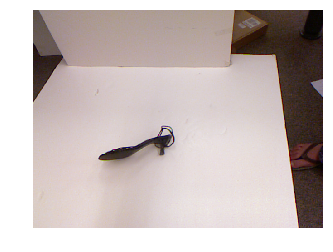

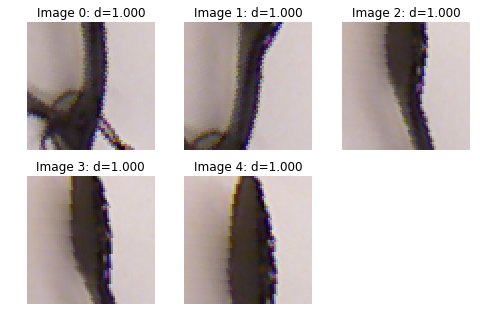

In [7]:
def visualize_image_tensor(cfg, idx, is_positive_example):
    grasps, img = load_cornell_grasp(cfg, idx, is_positive_example)
    print img.shape
    plt.figure()
    image_tensor, pose_tensor = grasps_to_tensors(cfg, grasps, img)
    visualize_image_pose_tensor(image_tensor, pose_tensor)
    
visualize_image_tensor(cfg, idx=110, is_positive_example=True)

In [ ]:
# pose_filenames = [f for f in all_filenames if f.find(ImageFileTemplates.hand_poses_template) > -1]
# label_filenames = [f for f in all_filenames if f.find(self.target_metric_name) > -1]
# # obj_id_filenames = [f for f in all_filenames if f.find(ImageFileTemplates.object_labels_template) > -1]
# # stable_pose_filenames = [f for f in all_filenames if f.find(ImageFileTemplates.pose_labels_template) > -1]
# im_filenames = [f for f in all_filenames if f.find(ImageFileTemplates.color_im_tf_tensor_template) > -1]

In [ ]:
def save_tensor(cfg, idx, color_image_tensor, pose_tensor, label_tensor):
    idx-=100
    directory = cfg["dataset_dir"]
    
    color_filename = os.path.join(directory, ImageFileTemplates.color_im_tf_tensor_template+str(idx))
    pose_filename = os.path.join(directory, ImageFileTemplates.hand_poses_template+str(idx))
    label_filename = os.path.join(directory, cfg["target_metric_name"]+str(idx))
    
    print color_filename
    print pose_filename
    print label_filename
    
    np.savez_compressed(color_filename, color_image_tensor)
    np.savez_compressed(pose_filename, pose_tensor)
    np.savez_compressed(label_filename, label_tensor)

In [ ]:
stored_config_path = os.path.join(cfg["dataset_dir"],"configuration_settings")
cfg.save(stored_config_path)

for idx in range(102,124):
    grasps, img = load_cornell_grasp(cfg, idx, is_positive_example=True)
    image_tensor, pose_tensor = grasps_to_tensors(cfg, grasps, img)
    label_tensor_positive = np.zeros([len(grasps)])
    save_tensor(cfg, idx, image_tensor, pose_tensor, label_tensor_positive)

In [ ]:
def load_tensor(cfg, idx):
    idx-=100
    directory = cfg["dataset_dir"]
    
    color_filename = os.path.join(directory, ImageFileTemplates.color_im_tf_tensor_template+str(idx)+".npz")
    pose_filename = os.path.join(directory, ImageFileTemplates.hand_poses_template+str(idx)+".npz")
    label_filename = os.path.join(directory, cfg["target_metric_name"]+str(idx)+".npz")
    
    print color_filename+".npz"
    print pose_filename+".npz"
    print label_filename+".npz"
    
    color_image_tensor = np.load(color_filename)['arr_0']
#     color_image_tensor.keys()
    
#     print color_image_tensor.keys()
    
    pose_tensor = np.load(pose_filename)['arr_0']
    label_tensor = np.load(label_filename)['arr_0']
    
    return color_image_tensor, pose_tensor, label_tensor

In [ ]:
idx = 109
color_image_tensor, pose_tensor, label_tensor = load_tensor(cfg, idx)
print color_image_tensor.shape
length = len(color_image_tensor[:,0,0,0])
d = int(ceil(sqrt(length)))
for i in range(1,length):
    plt.subplot(d,d,i)
    print color_image_tensor[i,...].shape
    plt.imshow(color_image_tensor[i,...])

In [ ]:
load_tensor(cfg, idx)
"bla"

In [ ]:
view_cornell_grasp(cfg,110,True)

In [10]:
a = 'BF'
a.lower()

'bf'

In [25]:
def is_finite(num):
    return not (float('Inf')==num or float('nan')==num)

In [31]:
is_finite(float('Nan'))

True

In [30]:
float('Nan')

nan